In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cmocean
import niskine

import cartopy.crs as ccrs


In [2]:
root_dir = '/Users/zcasparcohen/codes/NIW/data/'
figdir='/Users/zcasparcohen/codes/NIW/figures_vid/'

In [3]:
PI_omega = xr.open_dataarray(root_dir+'roms_energy_transfers_500m.nc')
ds_filt = xr.open_dataset(root_dir+'roms_filtered_500m.nc')
#[['u','v','u_filtered','v_filtered']]
midlon,midlat=PI_omega.lon.median(),PI_omega.lat.median()

In [4]:
ds_filt['ke_filtered'] = 0.5*(ds_filt.u_filtered**2+ds_filt.v_filtered**2)
ds_filt['ke_high'] = 0.5*((ds_filt.u-ds_filt.u_filtered)**2+(ds_filt.v-ds_filt.v_filtered)**2)

In [5]:
ds_mid,PI_mid = ds_filt.sel(lon=midlon,lat=midlat,method='nearest'),PI_omega.sel(lon=midlon,lat=midlat,method='nearest')
#ds_mid,PI_mid = ds_filt.interp(lon=midlon,lat=midlat),PI_omega.interp(lon=midlon,lat=midlat)

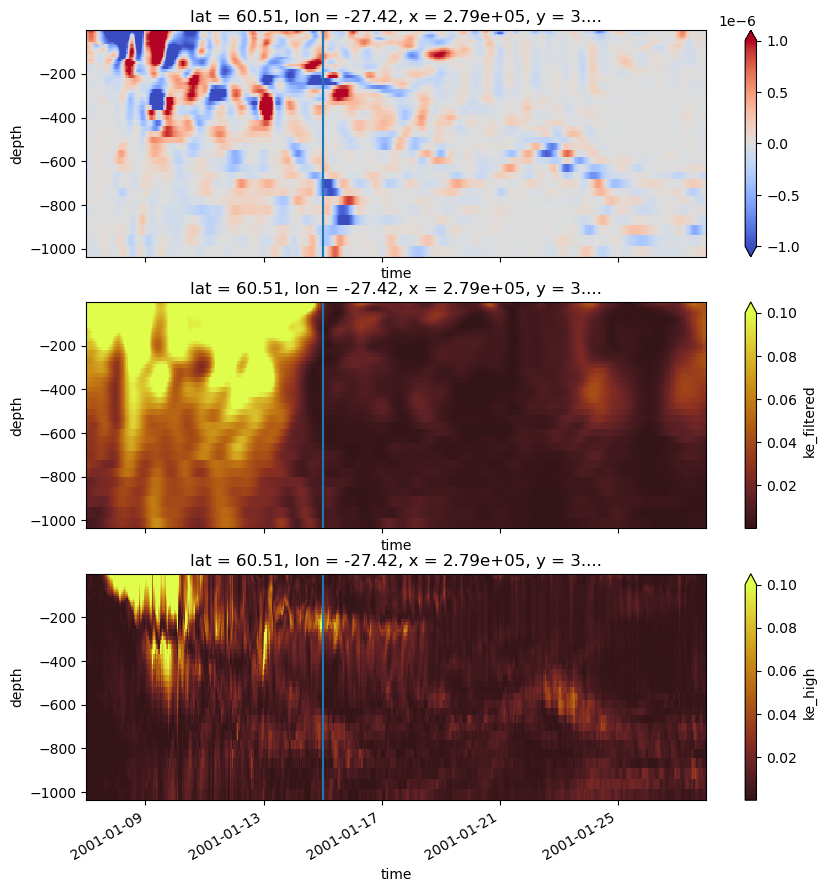

In [6]:
import pandas as pd
fig,ax=plt.subplots(3,1,figsize=(10,10),sharex=True)
PI_mid.plot(ax=ax[0],vmax=1e-6,cmap='coolwarm')
ds_mid.ke_filtered.plot(ax=ax[1],vmax=1e-1,cmap=cmocean.cm.solar)
ds_mid.ke_high.plot(ax=ax[2],vmax=1e-1,cmap=cmocean.cm.solar)
ax[0].set_xlim(np.datetime64('2001-01-07'),np.datetime64('2001-01-28'))
for a in ax:
    a.axvline(np.datetime64('2001-01-15'))

In [7]:
# Computing energy transfer rate
Sn = ds_filt.u_filtered.differentiate('x')-ds_filt.v_filtered.differentiate('y') #normal components of strain
S = ds_filt.u_filtered.differentiate('y')+ds_filt.v_filtered.differentiate('x') #shear component of strain
RV = ds_filt.v_filtered.differentiate('x')-ds_filt.u_filtered.differentiate('y')  #Relative vorticity
OW = Sn**2+S**2-RV**2 #OW parameter

In [8]:
OW_mid = OW.sel(lon=midlon,lat=midlat,method='nearest')
RV_mid = RV.sel(lon=midlon,lat=midlat,method='nearest')
#OW_mid = OW.interp(lon=midlon,lat=midlat)
#RV_mid = RV.interp(lon=midlon,lat=midlat)

In [9]:
def get_hist(ds,bins):
    # Flatten the 2D array to 1D
    flattened_data = ds.values.ravel()
    valid_data = flattened_data[~np.isnan(flattened_data)]
    # Compute histogram
    counts, bin_edges = np.histogram(valid_data, bins=bins, density=True)
    # Compute bin centers
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    # Compute PDF × value
    pdf_times_value = counts * np.abs(bin_centers)
    return pdf_times_value,bin_centers

def plot_hist(pi,ow,bins=50, plot=True):
    P_pos=pi.where((ow>0)&(pi>0))
    P_neg=pi.where((ow>0)&(pi<0))
    
    hist_pos,bin_pos = get_hist(P_pos,bins=bins)
    hist_neg,bin_neg = get_hist(P_neg,bins=bins)

    if plot:
    # Plot
        fig,axs=plt.subplots(1,2,figsize=(10,4),sharey=True)
        ax=axs[0]
        ax.plot(bin_pos, hist_pos, drawstyle='steps-mid', color='r', linewidth=2)
        ax.plot(-1*bin_neg, hist_neg, drawstyle='steps-mid', color='b', linewidth=2)
        ax.set_ylabel(r'PDf $\times$ $\Pi_\omega$ [m$^2$ s$^{-3}$]')
        ax.set_xlabel(r'$\Pi_\omega$ [m$^2$ s$^{-3}$]');ax.set_title(r'OW>0')
        ax.set_xlim(0,4e-6);#ax.set_ylim(0,None)
        ax.grid(True)
    
        P_pos=pi.where((ow<0)&(pi>0))
        P_neg=pi.where((ow<0)&(pi<0))
        
        hist_pos,bin_pos = get_hist(P_pos,bins=bins)
        hist_neg,bin_neg = get_hist(P_neg,bins=bins)
        
        # Plot
        ax=axs[1]
        ax.plot(bin_pos, hist_pos, drawstyle='steps-mid', color='r', linewidth=2,label=r'$\Pi_\omega>0$')
        ax.plot(-1*bin_neg, hist_neg, drawstyle='steps-mid', color='b', linewidth=2,label=r'$\Pi_\omega<0$')
        ax.set_ylabel(r'PDf $\times$ $\Pi_\omega$ [m$^2$ s$^{-3}$]')
        ax.set_xlabel(r'$\Pi_\omega$ [m$^2$ s$^{-3}$]');ax.set_title(r'OW<0')
        ax.set_xlim(0,4e-6);ax.set_ylim(0,0.4)
        ax.grid(True);ax.legend()
        return fig,axs
    else:
        P_pos_neg=pi.where((ow<0)&(pi>0))
        P_neg_neg=pi.where((ow<0)&(pi<0))
        
        hist_pos_neg,bin_pos_neg = get_hist(P_pos_neg,bins=bins)
        hist_neg_neg,bin_neg_neg = get_hist(P_neg_neg,bins=bins)
        return [hist_pos,hist_neg], [hist_pos_neg,hist_neg_neg], [bin_pos,bin_neg], [bin_pos_neg,bin_neg_neg]

(0.0, 0.6)

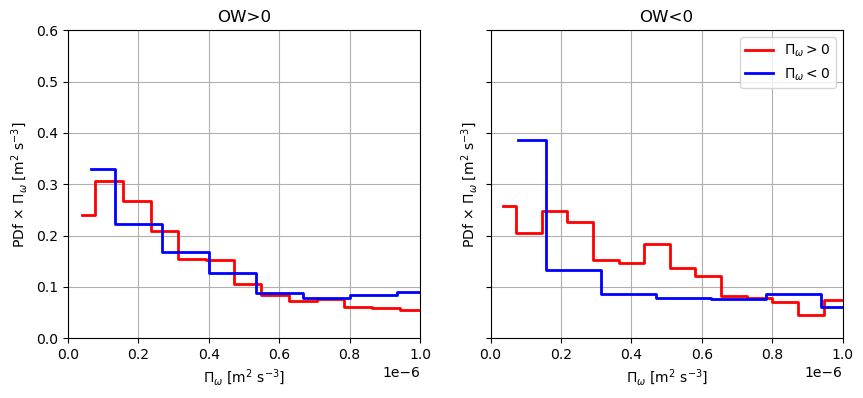

In [10]:
fig,axs=plot_hist(PI_mid,OW_mid)
axs[0].set_xlim(0,1e-6)
axs[1].set_xlim(0,1e-6)
axs[1].set_ylim(0,0.6)

In [11]:
conf = niskine.io.load_config()
m1lon, m1lat, m1bottom_depth = niskine.io.mooring_location(mooring=1)
m2lon, m2lat, m2bottom_depth = niskine.io.mooring_location(mooring=2)
m3lon, m3lat, m3bottom_depth = niskine.io.mooring_location(mooring=3)

def moorings_coords(lat,lon,midlat,ratio=1):
    diff_lat = (lat[0]-lat[1])*ratio
    diff_lon = (lon[1]-lon[2])*ratio
    M1lat,M1lon = midlat+diff_lat/2, midlon+diff_lon/2
    M2lat,M2lon = midlat-diff_lat/2, midlon+diff_lon/2
    M3lat,M3lon = midlat, midlon-diff_lon/2
    return M1lat,M2lat,M3lat,M1lon,M2lon,M3lon

In [12]:
#Moorings coordinates:
M1lat,M2lat,M3lat,M1lon,M2lon,M3lon = moorings_coords([m1lat,m2lat,m3lat],[m1lon,m2lon,m3lon],midlat,ratio=1)
#Coordinates of the center of the mooring array 
latitudes = [m*np.pi/180 for m in [M1lat,M2lat,M3lat]]
longitudes = [m*np.pi/180 for m in [M1lon,M2lon,M3lon]]
sumx = np.sum(np.cos(latitudes)*np.cos(longitudes))/3
sumy = np.sum(np.cos(latitudes)*np.sin(longitudes))/3
sumz = np.sum(np.sin(latitudes))/3
midlon1 = 180*np.arctan2(sumy,sumx)/np.pi
hyp = np.sqrt(sumx*sumx+sumy*sumy)
midlat1 = 180*np.arctan2(sumz,hyp)/np.pi

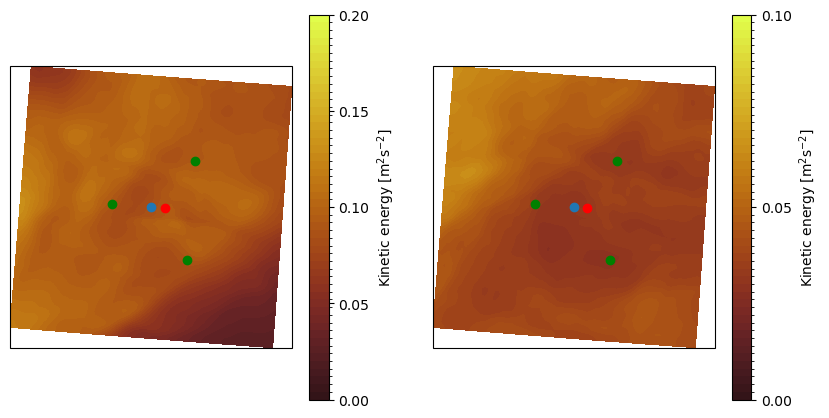

In [13]:
fig, axs = plt.subplots(ncols=2,
                        subplot_kw={'projection': ccrs.LambertConformal(central_longitude=-20.4,central_latitude=58.5)},
                        figsize=(10,5))
ds_filt.ke_filtered.sel(depth=0,method='nearest').mean('time').plot.contourf(ax=axs[0],
                                                                             x='lon', y='lat',
                                                                             vmin=0, vmax=2e-1,
                                                                             cmap=cmocean.cm.solar,
                                                                             transform=ccrs.PlateCarree(),
                                                                            levels=51,
                                                                             add_labels=False,add_colorbar=True,
                                                                             cbar_kwargs={'label':r'Kinetic energy [m$^2$s$^{-2}$]','ticks':np.arange(0,5e-1,5e-2)})
ds_filt.ke_high.sel(depth=0,method='nearest').mean('time').plot.contourf(ax=axs[1],
                                                                             x='lon', y='lat',
                                                                             vmin=0, vmax=1e-1,
                                                                             cmap=cmocean.cm.solar,
                                                                             transform=ccrs.PlateCarree(),
                                                                            levels=51,
                                                                             add_labels=False,add_colorbar=True,
                                                                             cbar_kwargs={'label':r'Kinetic energy [m$^2$s$^{-2}$]','ticks':np.arange(0,5e-1,5e-2)})

for ax in axs:
    ax.scatter(midlon,midlat,transform=ccrs.PlateCarree());ax.scatter(M1lon,M1lat,c='g',transform=ccrs.PlateCarree());
    ax.scatter(M2lon,M2lat,c='g',transform=ccrs.PlateCarree());ax.scatter(M3lon,M3lat,c='g',transform=ccrs.PlateCarree())
    ax.scatter(midlon1,midlat1,transform=ccrs.PlateCarree(),c='r')

In [14]:
if True:
    ds_mid1,PI_mid1 = ds_filt.sel(lon=midlon1,lat=midlat1,method='nearest'),PI_omega.sel(lon=midlon1,lat=midlat1,method='nearest')
    OW_mid1 = OW.sel(lon=midlon1,lat=midlat1,method='nearest')
    RV_mid1 = RV.sel(lon=midlon1,lat=midlat1,method='nearest')

if False:
    ds_mid1,PI_mid1 = ds_filt.interp(lon=midlon1,lat=midlat1),PI_omega.interp(lon=midlon1,lat=midlat1)
    OW_mid1 = OW.interp(lon=midlon1,lat=midlat1)
    RV_mid1 = RV.interp(lon=midlon1,lat=midlat1)

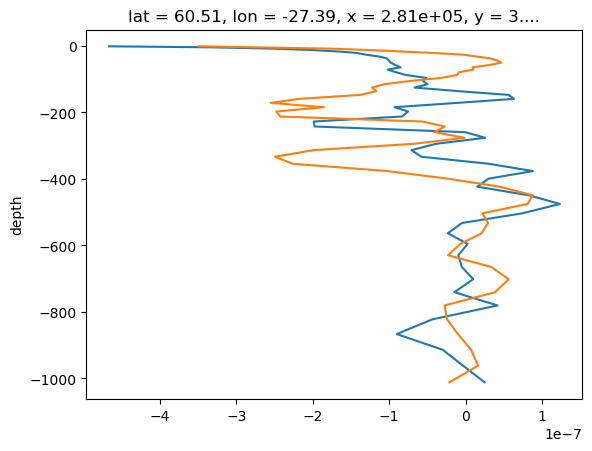

In [15]:
PI_mid.sel(time=slice(None,'2001-01-15')).mean('time').plot(y='depth')
PI_mid1.sel(time=slice(None,'2001-01-15')).mean('time').plot(y='depth')

In [16]:
if True:
    M1,PI_M1 = ds_filt.sel(lon=M1lon,lat=M1lat,method='nearest'),PI_omega.sel(lon=M1lon,lat=M1lat,method='nearest')
    M2,PI_M2 = ds_filt.sel(lon=M2lon,lat=M2lat,method='nearest'),PI_omega.sel(lon=M2lon,lat=M2lat,method='nearest')
    M3,PI_M3 = ds_filt.sel(lon=M3lon,lat=M3lat,method='nearest'),PI_omega.sel(lon=M3lon,lat=M3lat,method='nearest')

if False:
    M1,PI_M1 = ds_filt.interp(lon=M1lon,lat=M1lat),PI_omega.interp(lon=M1lon,lat=M1lat)
    M2,PI_M2 = ds_filt.interp(lon=M2lon,lat=M2lat),PI_omega.interp(lon=M2lon,lat=M2lat)
    M3,PI_M3 = ds_filt.interp(lon=M3lon,lat=M3lat),PI_omega.interp(lon=M3lon,lat=M3lat)

In [17]:
moorings={'1':M1,'2':M2,'3':M3}
PI_moorings={'1':PI_M1,'2':PI_M2,'3': PI_M3}

In [18]:
import gsw
import mplniw.utils as ut
import pandas as pd
def get_mid(moorings,mlat=midlat,mlon=midlon,col='usq'):
    """ Interpolate variable at the center  of the mooring triangular array using all moorings measurements.
    ----------------------------------------------------
    Parameters:
    moorings: dict, contains the three moorings xarray datasets
    col:str, variable to interpolate
    ----------------------------------------------------
    Returns:
    ds_mid:DataArray, interpolated variable
    """
    ds_mid = xr.combine_by_coords([moorings[k].expand_dims(['lon','lat']).drop(['x','y']) for k in moorings])
    #xr.merge([moorings[k][col] for k in moorings])
    ds_mid[col]=ds_mid[col].interpolate_na(dim='time',max_gap=pd.Timedelta('1D'))
    ds_mid[col]=ds_mid[col].fillna(0).interp(lat=mlat,lon=mlon,method='slinear')
    ds_mid[col]=ds_mid[col].where(ds_mid[col]!=0)
    return ds_mid[col]
    
def transfers_moorings(mooring,pi,lats,lons):
    # Computing distance and horizontal gradients (triangle approximation)
    M1lon,M2lon,M3lon=lons
    M1lat,M2lat,M3lat=lats
    dM1_N = gsw.distance([(M1lon+M3lon)/2,M1lon],[(M1lat+M3lat)/2,M1lat])
    dM3_N = gsw.distance([(M1lon+M3lon)/2,M3lon],[(M1lat+M3lat)/2,M3lat])
    dM3_S = gsw.distance([(M2lon+M3lon)/2,M3lon],[(M2lat+M3lat)/2,M3lat])
    dM2_S = gsw.distance([(M2lon+M3lon)/2,M2lon],[(M2lat+M3lat)/2,M2lat])
    
    dx_W = gsw.distance([midlon,M3lon],[midlat,midlat])
    dx_E = gsw.distance([midlon,(M1lon+M2lon)/2],[midlat,midlat])
    dy_NE = gsw.distance([midlon,midlon],[midlat,M1lat])
    dy_SE = gsw.distance([midlon,midlon],[midlat,M2lat])
    ueast = (moorings['1'].u_filtered*dy_SE+moorings['2'].u_filtered*dy_NE)/(dy_NE+dy_SE)
    veast = (moorings['1'].v_filtered*dy_SE+moorings['2'].v_filtered*dy_NE)/(dy_NE+dy_SE)
    uwest = moorings['3'].u_filtered
    vwest = moorings['3'].v_filtered
    unorth = (moorings['1'].u_filtered*dM3_N+moorings['3'].u_filtered*dM1_N)/(dM1_N+dM3_N)
    vnorth = (moorings['1'].v_filtered*dM3_N+moorings['3'].v_filtered*dM1_N)/(dM1_N+dM3_N)
    usouth = (moorings['2'].u_filtered*dM3_S+moorings['3'].u_filtered*dM2_S)/(dM2_S+dM3_S)
    vsouth = (moorings['2'].v_filtered*dM3_S+moorings['3'].v_filtered*dM2_S)/(dM2_S+dM3_S)
    ux = (ueast-uwest)/((dx_W+dx_E))
    vx = (veast-vwest)/((dx_W+dx_E))
    uy = (unorth-usouth)/((dy_NE+dy_SE)/2)
    vy = (vnorth-vsouth)/((dy_NE+dy_SE)/2)

    # interpolating needed variables to the center of the square mooring array
    usqf_mid=get_mid(moorings,mlat=midlat,mlon=midlon,col='usq_filtered')  #filtered u squared
    vsqf_mid=get_mid(moorings,mlat=midlat,mlon=midlon,col='vsq_filtered')  #filtered v squared
    uvf_mid=get_mid(moorings,mlat=midlat,mlon=midlon,col='uv_filtered')    #filtered u*v
    uf_mid=get_mid(moorings,mlat=midlat,mlon=midlon,col='u_filtered')  #filtered u
    vf_mid=get_mid(moorings,mlat=midlat,mlon=midlon,col='v_filtered')  #filtered v
    usq_mid =get_mid(moorings,mlat=midlat,mlon=midlon,col='usq')   #raw u squared
    vsq_mid =get_mid(moorings,mlat=midlat,mlon=midlon,col='vsq')   #raw v squared

    # Computing energy transfer rate
    Sn_M = ux-vy #normal components of strain
    S_M = uy+vx #shear component of strain
    RV_M = vx-uy  #Relative vorticity
    OW_M = Sn_M**2+S_M**2-RV_M**2 #OW parameter
    P = -((usqf_mid-uf_mid**2)*ux + (vsqf_mid-vf_mid**2)*vy + (uvf_mid-uf_mid*vf_mid)*(uy+vx))
    P_mid = -((ds_mid.usq_filtered-ds_mid.u_filtered**2)*ux + (ds_mid.vsq_filtered-ds_mid.v_filtered**2)*vy + (ds_mid.uv_filtered-ds_mid.u_filtered*ds_mid.v_filtered)*(uy+vx))
    return P,P_mid,OW_M,RV_M

In [19]:
P,P_mid,OW_M,RV_M = transfers_moorings(moorings,PI_moorings,[M1lat,M2lat,M3lat],[M1lon,M2lon,M3lon])

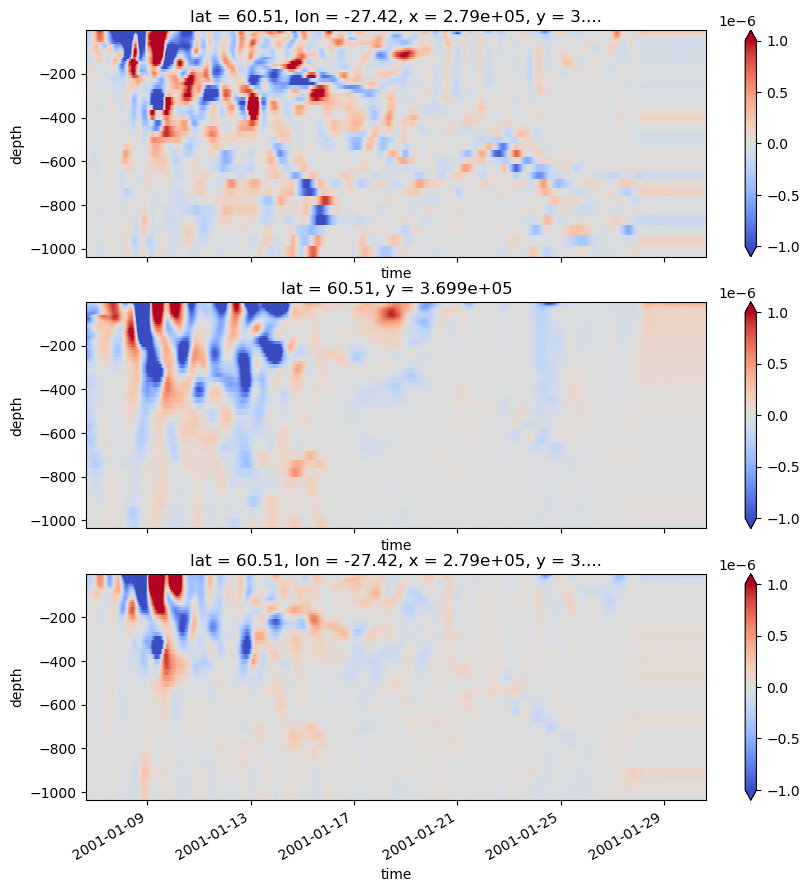

In [20]:

fig,ax=plt.subplots(3,1,figsize=(10,10),sharex=True)
PI_mid.plot(ax=ax[0],vmax=1e-6,cmap='coolwarm')
P.plot(ax=ax[1],vmax=1e-6,cmap='coolwarm')
P_mid.plot(ax=ax[2],vmax=1e-6,cmap='coolwarm')
#((P-PI_mid)/PI_mid).plot(ax=ax[2],vmax=1)

(0.0, 0.6)

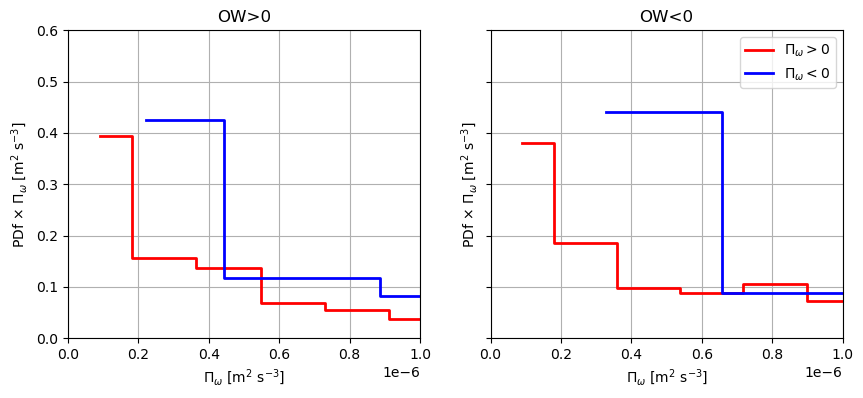

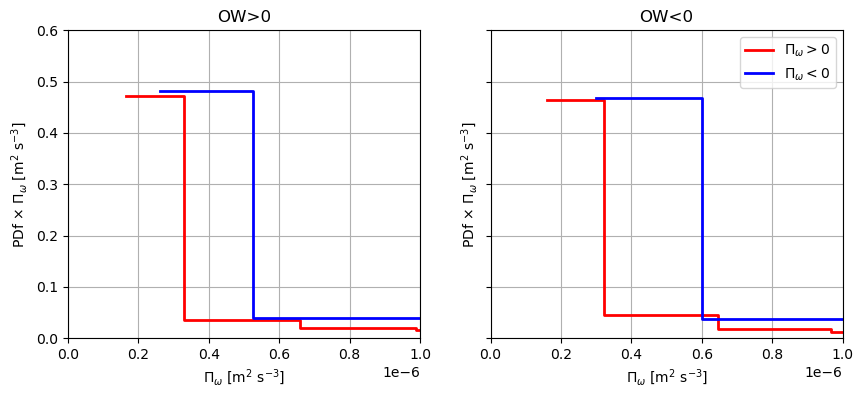

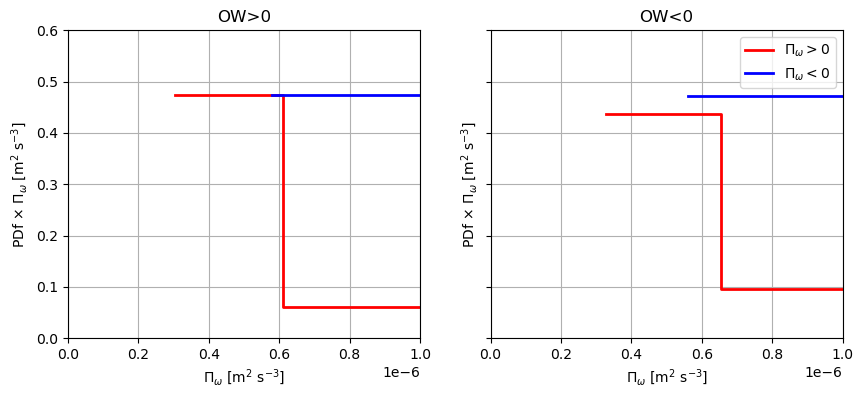

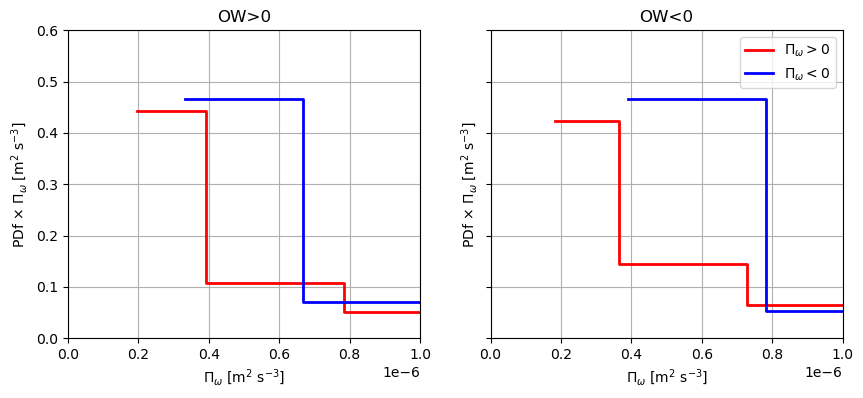

In [21]:
fig,axs=plot_hist(P,OW_M,bins=10)
for ax in axs:
    ax.set_xlim(0,1e-6)
axs[1].set_ylim(0,0.6);

fig,axs=plot_hist(P_mid,OW_M,bins=10)
for ax in axs:
    ax.set_xlim(0,1e-6)
axs[1].set_ylim(0,0.6)

fig,axs=plot_hist(PI_mid1,OW_mid1,bins=10)
for ax in axs:
    ax.set_xlim(0,1e-6)
axs[1].set_ylim(0,0.6)
fig,axs=plot_hist(PI_mid,OW_mid,bins=10)
for ax in axs:
    ax.set_xlim(0,1e-6)
axs[1].set_ylim(0,0.6)

In [31]:
#Moorings coordinates:
M1lat,M2lat,M3lat,M1lon,M2lon,M3lon = moorings_coords([m1lat,m2lat,m3lat],[m1lon,m2lon,m3lon],midlat,ratio=0.5)
M1lat_15,M2lat_15,M3lat_15,M1lon_15,M2lon_15,M3lon_15 = moorings_coords([m1lat,m2lat,m3lat],[m1lon,m2lon,m3lon],midlat,ratio=1.5)

In [32]:
if True:
    M1_05,PI_M1_05 = ds_filt.sel(lon=M1lon,lat=M1lat,method='nearest'),PI_omega.sel(lon=M1lon,lat=M1lat,method='nearest')
    M2_05,PI_M2_05 = ds_filt.sel(lon=M2lon,lat=M2lat,method='nearest'),PI_omega.sel(lon=M2lon,lat=M2lat,method='nearest')
    M3_05,PI_M3_05 = ds_filt.sel(lon=M3lon,lat=M3lat,method='nearest'),PI_omega.sel(lon=M3lon,lat=M3lat,method='nearest')

if False:
    M1_05,PI_M1_05 = ds_filt.interp(lon=M1lon,lat=M1lat),PI_omega.interp(lon=M1lon,lat=M1lat)
    M2_05,PI_M2_05 = ds_filt.interp(lon=M2lon,lat=M2lat),PI_omega.interp(lon=M2lon,lat=M2lat)
    M3_05,PI_M3_05 = ds_filt.interp(lon=M3lon,lat=M3lat),PI_omega.interp(lon=M3lon,lat=M3lat)

if True:
    M1_15,PI_M1_15 = ds_filt.sel(lon=M1lon_15,lat=M1lat_15,method='nearest'),PI_omega.sel(lon=M1lon_15,lat=M1lat_15,method='nearest')
    M2_15,PI_M2_15 = ds_filt.sel(lon=M2lon_15,lat=M2lat_15,method='nearest'),PI_omega.sel(lon=M2lon_15,lat=M2lat_15,method='nearest')
    M3_15,PI_M3_15 = ds_filt.sel(lon=M3lon_15,lat=M3lat_15,method='nearest'),PI_omega.sel(lon=M3lon_15,lat=M3lat_15,method='nearest')

if False:
    M1_15,PI_M1_15 = ds_filt.interp(lon=M1lon_15,lat=M1lat_15),PI_omega.interp(lon=M1lon_15,lat=M1lat_15)
    M2_15,PI_M2_15 = ds_filt.interp(lon=M2lon_15,lat=M2lat_15),PI_omega.interp(lon=M2lon_15,lat=M2lat_15)
    M3_15,PI_M3_15 = ds_filt.interp(lon=M3lon_15,lat=M3lat_15),PI_omega.interp(lon=M3lon_15,lat=M3lat_15)

In [33]:
moorings_05={'1':M1_05,'2':M2_05,'3':M3_05}
PI_moorings_05={'1':PI_M1_05,'2':PI_M2_05,'3': PI_M3_05}

moorings_15={'1':M1_15,'2':M2_15,'3':M3_15}
PI_moorings_15={'1':PI_M1_15,'2':PI_M2_15,'3': PI_M3_15}

In [34]:
P_05,P_mid_05,OW_M_05,RV_M_05 = transfers_moorings(moorings_05,PI_moorings_05,[M1lat,M2lat,M3lat],[M1lon,M2lon,M3lon])
P_15,P_mid_15,OW_M_15,RV_M_15 = transfers_moorings(moorings_15,PI_moorings_15,[M1lat_15,M2lat_15,M3lat_15],[M1lon_15,M2lon_15,M3lon_15])

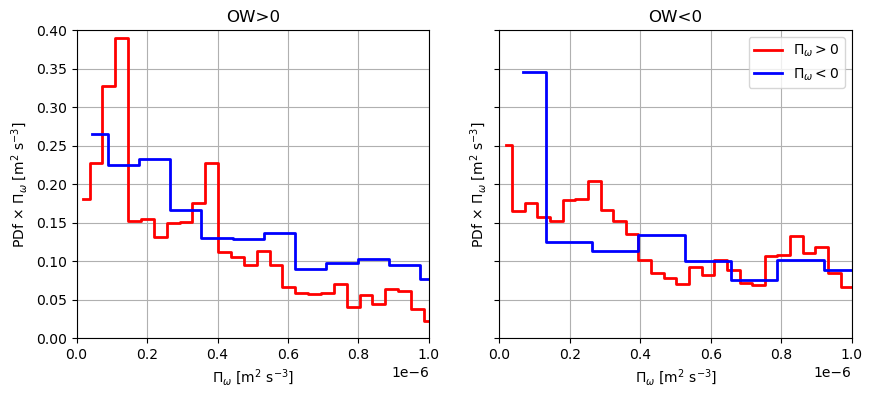

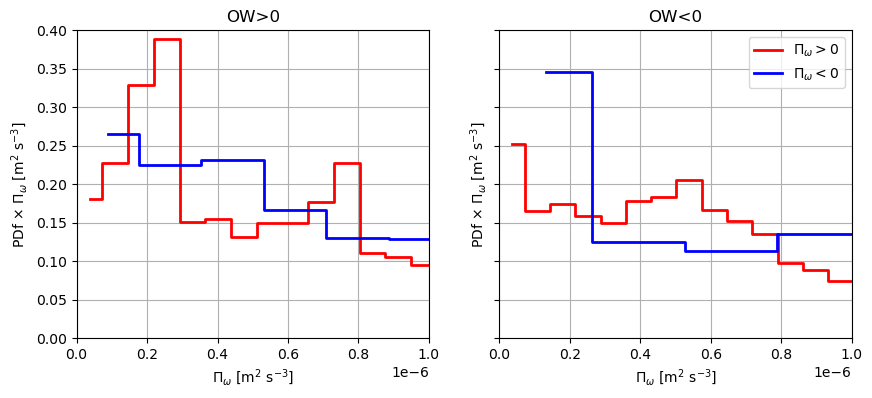

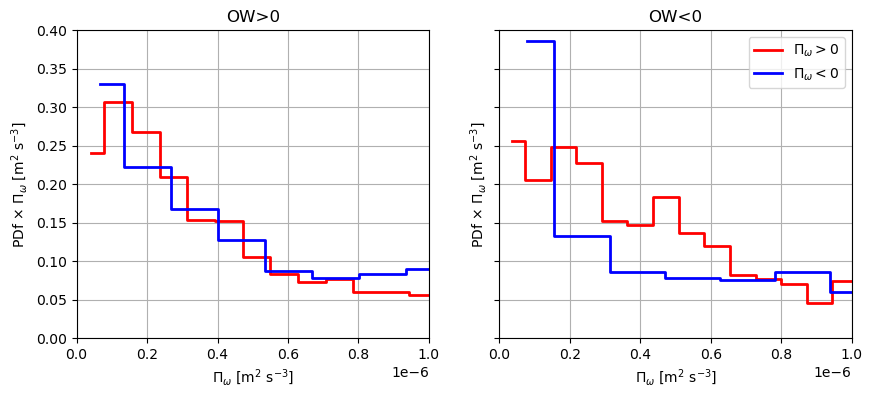

In [26]:
fig,axs=plot_hist(P,OW_M,bins=50)
for ax in axs:
    ax.set_xlim(0,1e-6)
axs[1].set_ylim(0,0.4);
fig,axs=plot_hist(P_05,OW_M_05,bins=50)
for ax in axs:
    ax.set_xlim(0,1e-6)
axs[1].set_ylim(0,0.4);
fig,axs=plot_hist(PI_mid,OW_mid,bins=50)
for ax in axs:
    ax.set_xlim(0,1e-6)
axs[1].set_ylim(0,0.4);

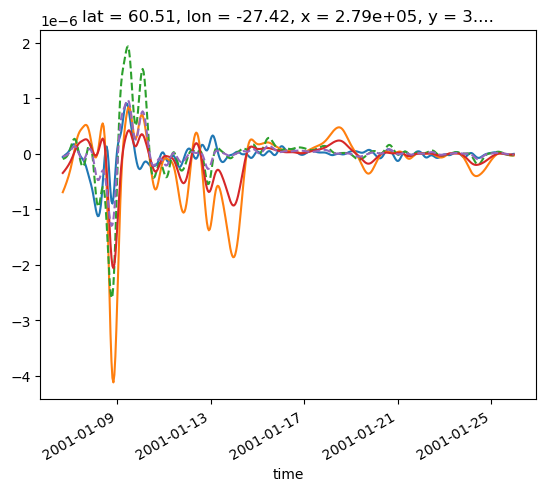

In [27]:
PI_mid.sel(time=slice(None,'2001-01-25')).mean('depth').plot()
P_05.sel(time=slice(None,'2001-01-25')).mean('depth').plot()
P_mid_05.sel(time=slice(None,'2001-01-25')).mean('depth').plot(ls='--')
P.sel(time=slice(None,'2001-01-25')).mean('depth').plot()
P_mid.sel(time=slice(None,'2001-01-25')).mean('depth').plot(ls='--')

In [35]:
P_hist,P_bins = get_hist(P,bins=50)
Pmid_hist,Pmid_bins = get_hist(P_mid,bins=50)
P05mid_hist,P05mid_bins = get_hist(P_mid_05,bins=50)
P05_hist,P05_bins = get_hist(P_05,bins=50)
P15mid_hist,P15mid_bins = get_hist(P_mid_15,bins=50)
P15_hist,P15_bins = get_hist(P_15,bins=50)
PImid_hist,PImid_bins = get_hist(PI_mid,bins=50)

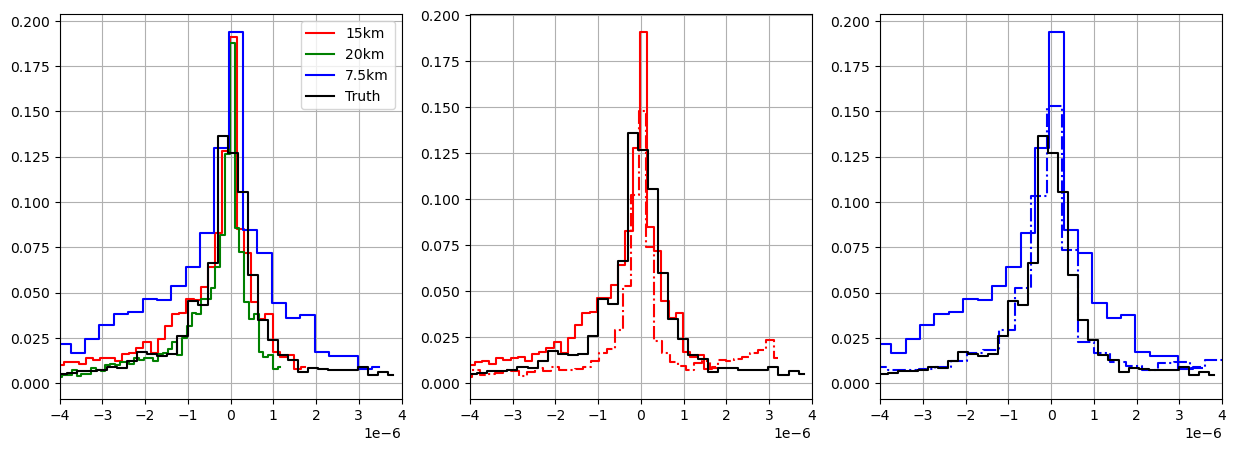

In [38]:
fig,axs=plt.subplots(1,3,figsize=(15,5))
ax=axs[0]
ax.plot(P_bins,P_hist,drawstyle='steps-mid',c='r',label='15km')
ax.plot(P15_bins,P15_hist,drawstyle='steps-mid',c='g',label='20km')
ax.plot(P05_bins,P05_hist,drawstyle='steps-mid',c='b',label='7.5km')
ax.plot(PImid_bins,PImid_hist,drawstyle='steps-mid',c='k',label='Truth')
ax.legend()

ax=axs[1]
ax.plot(P_bins,P_hist,drawstyle='steps-mid',c='r')
ax.plot(Pmid_bins,Pmid_hist,drawstyle='steps-mid',c='r',ls='-.')
ax.plot(PImid_bins,PImid_hist,drawstyle='steps-mid',c='k')

ax=axs[2]
ax.plot(P05_bins,P05_hist,drawstyle='steps-mid',c='b')
ax.plot(P05mid_bins,P05mid_hist,drawstyle='steps-mid',c='b',ls='-.')
ax.plot(PImid_bins,PImid_hist,drawstyle='steps-mid',c='k')

for ax in axs:
    ax.grid();ax.set_xlim(-4e-6,4e-6);

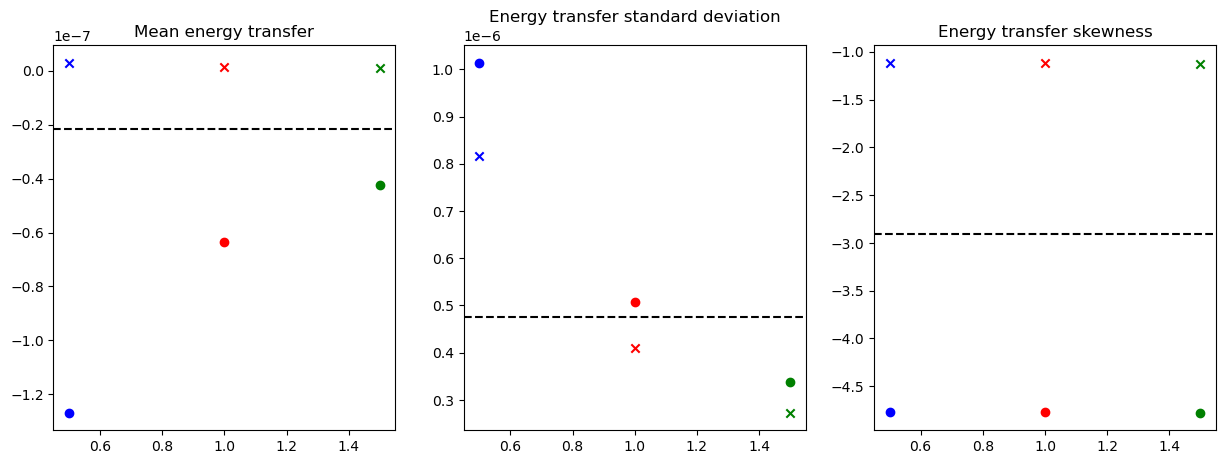

In [40]:
import scipy
fig,axs=plt.subplots(1,3,figsize=(15,5))
ax=axs[0]
#ax.scatter(0.5,np.abs(P_05).mean(),c='b')
#ax.scatter(0.5,np.abs(P_mid_05).mean(),c='b',marker='x')
#ax.scatter(1,np.abs(P).mean(),c='r')
#ax.scatter(1,np.abs(P_mid).mean(),c='r',marker='x')
#ax.axhline(np.abs(PI_mid).mean(),c='k',ls='--')
#ax.set_title('Mean absolute energy transfer')

ax.scatter(0.5,(P_05).mean(),c='b')
ax.scatter(0.5,(P_mid_05).mean(),c='b',marker='x')
ax.scatter(1.5,(P_15).mean(),c='g')
ax.scatter(1.5,(P_mid_15).mean(),c='g',marker='x')
ax.scatter(1,(P).mean(),c='r')
ax.scatter(1,(P_mid).mean(),c='r',marker='x')
ax.axhline((PI_mid).mean(),c='k',ls='--')
ax.set_title('Mean energy transfer')


ax=axs[1]
ax.scatter(0.5,P_05.std(),c='b')
ax.scatter(0.5,P_mid_05.std(),c='b',marker='x')
ax.scatter(1.5,(P_15).std(),c='g')
ax.scatter(1.5,(P_mid_15).std(),c='g',marker='x')
ax.scatter(1,P.std(),c='r')
ax.scatter(1,P_mid.std(),c='r',marker='x')
ax.axhline(PI_mid.std(),c='k',ls='--');
ax.set_title('Energy transfer standard deviation');

ax=axs[2]
ax.scatter(0.5,scipy.stats.skew(P_05.values.flatten()),c='b')
ax.scatter(0.5,scipy.stats.skew(P_mid_05.values.flatten()),c='b',marker='x')
ax.scatter(1.5,scipy.stats.skew(P_15.values.flatten()),c='g')
ax.scatter(1.5,scipy.stats.skew(P_mid_15.values.flatten()),c='g',marker='x')
ax.scatter(1,scipy.stats.skew(P.values.flatten()),c='r')
ax.scatter(1,scipy.stats.skew(P_mid.values.flatten()),c='r',marker='x')
ax.axhline(scipy.stats.skew(PI_mid.values.flatten()),c='k',ls='--');
ax.set_title('Energy transfer skewness');

Text(0.5, 1.0, 'Distance:20km')

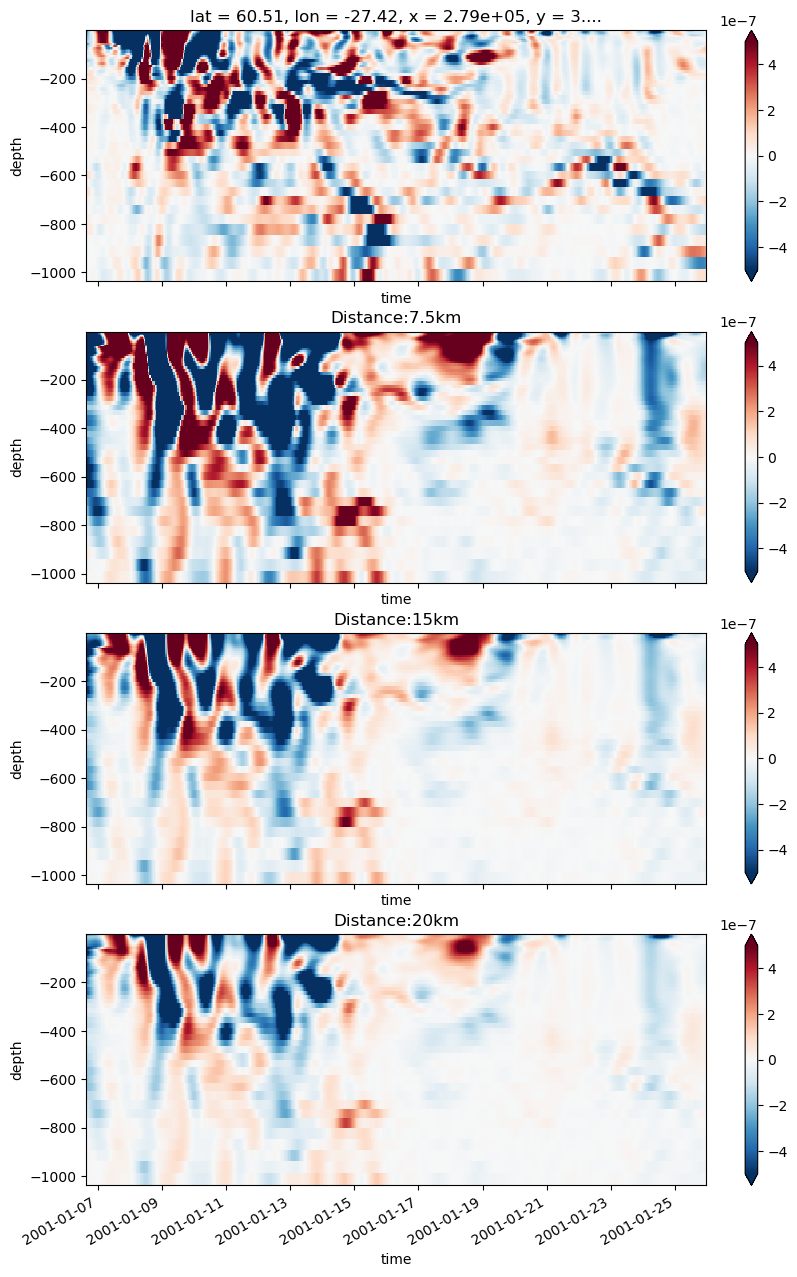

In [71]:
# Why is the mean better when distance is higher?
fig,axs=plt.subplots(4,1,figsize=(10,15),sharex=True)
PI_mid.sel(time=slice(None,'2001-01-25')).plot(ax=axs[0],vmax=5e-7)
P_05.sel(time=slice(None,'2001-01-25')).plot(ax=axs[1],vmax=5e-7)
P.sel(time=slice(None,'2001-01-25')).plot(ax=axs[2],vmax=5e-7)
P_15.sel(time=slice(None,'2001-01-25')).plot(ax=axs[3],vmax=5e-7)
axs[1].set_title('Distance:7.5km');
axs[2].set_title('Distance:15km');axs[3].set_title('Distance:20km')

Text(0.5, 1.0, 'Distance:20km')

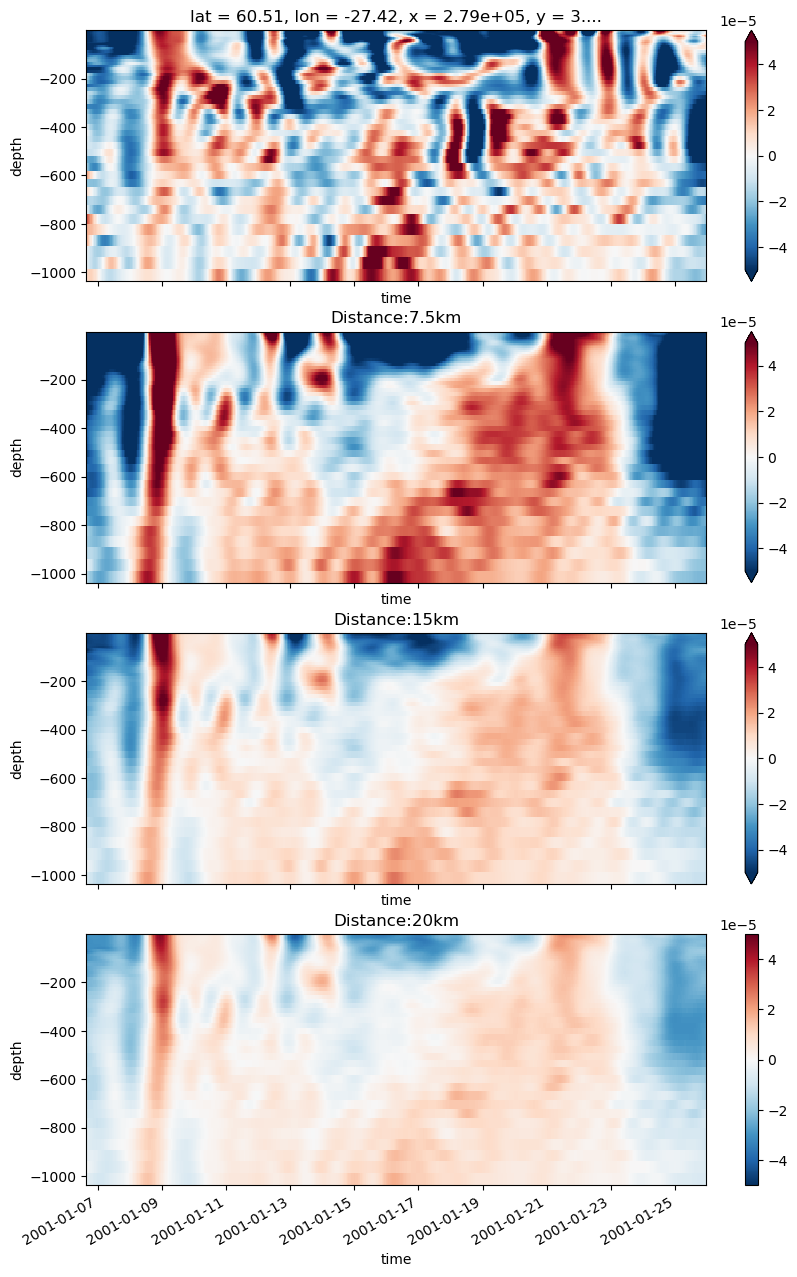

In [58]:
# Why is the mean better when distance is higher?
fig,axs=plt.subplots(4,1,figsize=(10,15),sharex=True)
RV.sel(lon=midlon,lat=midlat).sel(time=slice(None,'2001-01-25')).plot(ax=axs[0],vmax=5e-5)
RV_M_05.sel(time=slice(None,'2001-01-25')).plot(ax=axs[1],vmax=5e-5)
RV_M.sel(time=slice(None,'2001-01-25')).plot(ax=axs[2],vmax=5e-5)
RV_M_15.sel(time=slice(None,'2001-01-25')).plot(ax=axs[3],vmax=5e-5)
axs[1].set_title('Distance:7.5km');
axs[2].set_title('Distance:15km');axs[3].set_title('Distance:20km')

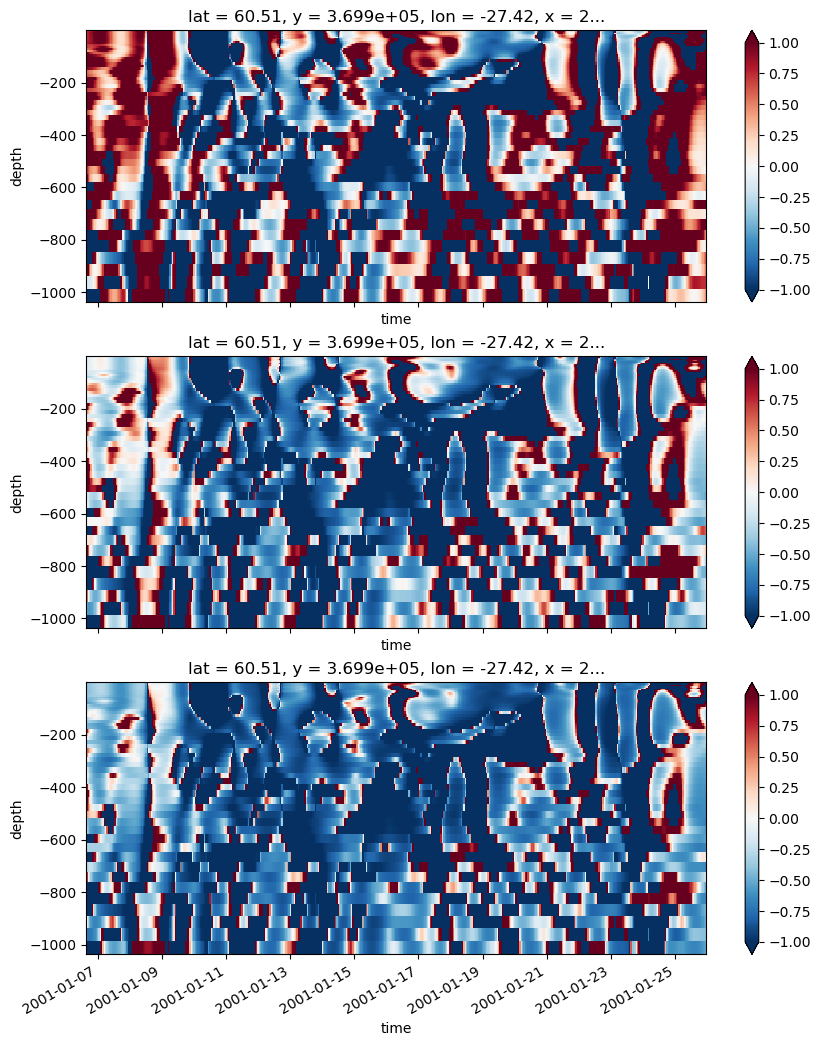

In [61]:
fig,axs=plt.subplots(3,1,figsize=(10,12),sharex=True)
((RV_M_05-RV.sel(lon=midlon,lat=midlat))/RV.sel(lon=midlon,lat=midlat)).sel(time=slice(None,'2001-01-25')).plot(ax=axs[0],vmax=1)
((RV_M-RV.sel(lon=midlon,lat=midlat))/RV.sel(lon=midlon,lat=midlat)).sel(time=slice(None,'2001-01-25')).plot(ax=axs[1],vmax=1)
((RV_M_15-RV.sel(lon=midlon,lat=midlat))/RV.sel(lon=midlon,lat=midlat)).sel(time=slice(None,'2001-01-25')).plot(ax=axs[2],vmax=1)
#RV_M.sel(time=slice(None,'2001-01-25')).plot(ax=axs[1])
#RV_M_05.sel(time=slice(None,'2001-01-25')).plot(ax=axs[2])
#RV_M_15.sel(time=slice(None,'2001-01-25')).plot(ax=axs[3])

Text(0.5, 1.0, 'Distance:20km')

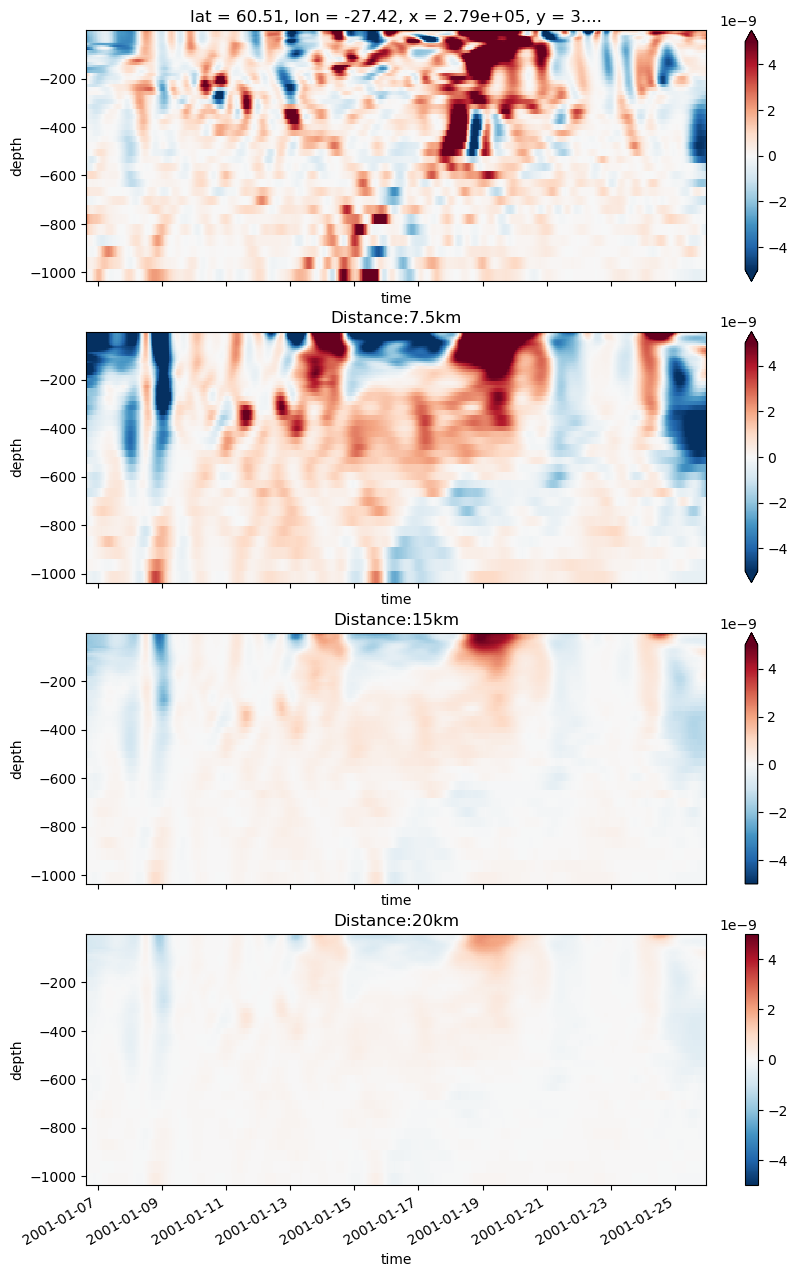

In [67]:
fig,axs=plt.subplots(4,1,figsize=(10,15),sharex=True)
OW_mid.sel(time=slice(None,'2001-01-25')).plot(ax=axs[0],vmax=5e-9)
OW_M_05.sel(time=slice(None,'2001-01-25')).plot(ax=axs[1],vmax=5e-9)
OW_M.sel(time=slice(None,'2001-01-25')).plot(ax=axs[2],vmax=5e-9)
OW_M_15.sel(time=slice(None,'2001-01-25')).plot(ax=axs[3],vmax=5e-9)
axs[1].set_title('Distance:7.5km');
axs[2].set_title('Distance:15km');axs[3].set_title('Distance:20km')